In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PPTM.embedded_score import UMAP_Fast, Embedded_SCORE_C
from PPTM.utils import *
import spacy
from scipy.special import digamma
import pickle
import re

# Download spaCy's small English model
# python -m spacy download en_core_web_sm

# Load spaCy's small English model
nlp = spacy.load('en_core_web_sm')


/Users/yguo23/Desktop/Projects/newContextualizedTopicScore/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Load AP dataset**

In [2]:
with np.load(
  "./npz/0331114438/AP_bert_c_10_metadata.npz", "rb", allow_pickle=True
) as data:
  vocab = data["dic"]
  word_freq = data["word_freq"]
  word_count = data["word_count"]
  min_word_count = data["min_word_count"]
  doc_indices = data["doc_indices"]
  num_doc = data["num_doc"]
  num_word = data["num_word"]
  dim = data["dim"]

# NOTE: This takes roughly 30s.
with np.load("./npz/0331114438/AP_bert_c_10_repr.npz", "rb") as data:
  doc_lens = np.array([len(data[f"doc_{doc_id}_txt"]) for doc_id in doc_indices])
  word_arr = np.hstack([data[f"doc_{doc_id}_txt"] for doc_id in doc_indices]).tolist()
  word_arr = [word.lower() for word in word_arr]
  spaces = [True] * (len(word_arr) - 1) + [False]  # Assume
  doc = spacy.tokens.Doc(nlp.vocab, words=word_arr, spaces=spaces)
  doc = nlp(doc)
  word_arr = [token.lemma_ for token in doc]
  np.save("./npz/0331114438/AP_word_arr_lemma_7145.npy", word_arr)
word_arr = np.load("./npz/0331114438/AP_word_arr_lemma_7145.npy")

with open("dataset/AP/raw_text.txt", "r") as file:
  content = file.read()
paragraphs = np.array(re.findall(r"<TEXT>(.*?)</TEXT>", content, re.DOTALL))

### **Fit umap model**

PPTM fits a umap model to reduce 762 dimensional BERT-pretrained embedding to a 10 dimensional space using 20\% data. This takes roughly 3 mins on PC.

In [3]:
# NOTE: Uncomment the following code if you want to fit a umap model yourself. This takes roughly 3 mins.
# umap_model_org.transform(bert_word_arr[:50000,:])
# problem fix: use 50000 instead of 10000

seed = 2024
umap_get = UMAP_Fast(
  new_dim=10,
  n_neighbors=10,
  min_dist=0.1,
  fit_prop=0.2,
  npy_path="npz/0331114438/AP_bert_c_10_combined_repr.npy",
  tick="AP",
  random_seed=seed,
)
umap_get.transform_all_points(
  dump_dir="./pkl/0331114438",
  save_dir="./npz/0331114438",
  batch_size=50000
)
# del umap_get

pts shape for fitting umap is:(78340, 768)


/Users/yguo23/Desktop/Projects/newContextualizedTopicScore/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


finishing fitting umap


Transforming in mini-batches: 100%|██████████| 8/8 [00:58<00:00,  7.36s/it]

finishing transform word_repr


array([[7.683923 , 2.945612 , 4.719322 , ..., 6.056865 , 7.9586277,
        6.06601  ],
       [8.402907 , 3.8041687, 4.566574 , ..., 4.403221 , 4.746011 ,
        3.9712217],
       [8.187813 , 5.0665536, 4.5830903, ..., 8.021612 , 3.4571838,
        6.0884533],
       ...,
       [9.50402  , 3.738099 , 5.1870933, ..., 6.1467233, 4.309548 ,
        5.1946635],
       [8.25156  , 3.6014667, 5.3790154, ..., 6.02008  , 4.7971168,
        5.905986 ],
       [8.269224 , 4.4084654, 5.498884 , ..., 3.3727906, 4.959587 ,
        4.849294 ]], dtype=float32)

### **Run PPTM**

Uncomment the following code if you want to fit yourself. The fitting will take roughly 5 mins on PC.

number of hyperwords is 600
using mini-batch kmeans to get hyperwords...
available methods: mini-batch kmeans, kmeans, kmeans-constrained, hierarchical
begin mini-batch clustering w/ num_init=100
finishing mini-batch clustering
In fit_topic_socre:
number of topic is set as 7
using SPA as the vertex hunting algorithm...
start calculating W_hat


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]

finish fitting TS


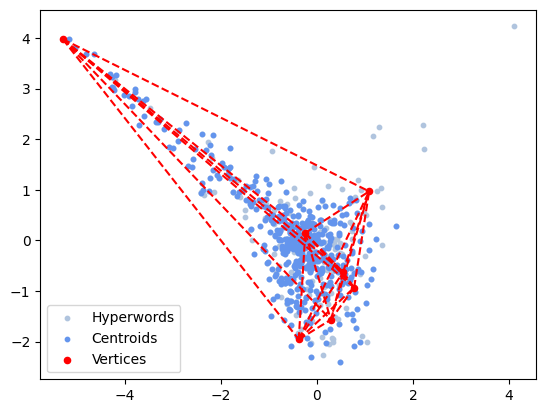

bandwidth is 0.1


Calculating word densities.: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


In [4]:
# NOTE: Uncomment the following code if you want to fit yourself. This takes roughly 5 mins. 
seed = 2024
init_num = 100
num_topic=7
num_hyperword=600
es_model = Embedded_SCORE_C(
  num_doc=num_doc,
  doc_lens=doc_lens,
  num_topic=num_topic,
  num_hyperword=num_hyperword,
  npy_path=f"npz/0331114438/AP_word_umap_10_nn_10_mdist_0.1_sample_0.2_seed_2024.npy",
  dim_repr=10,
  tick="AP",
  random_seed=seed,
  clustering_method="mini-batch kmeans",
  vertex_hunting_method="SPA",
  remove_outlier=True,
  cluster_first=False,
  contamination=0.2,
  n_neighbors=10,
  num_init = init_num,
  quantile=0.95,
  percentage=0.05,
  num_batches_cal_W_hat = 2,
  num_batches_cal_density = 2,
  calculate_right_matrix=True,
  calculate_W_hat=True
)
es_model.fit_all()

# Save es_model.
with open(f"./pkl/0331114438/AP_sample_0.2_nhyper_{num_hyperword}_seed_{seed}.pkl", "wb") as file:
    pickle.dump(es_model,file)

# Load saved es_model.
with open("./pkl/0331114438/AP_sample_0.2_nhyper_600_seed_2024.pkl", "rb") as file:
    es_model = pickle.load(file)

### **Top words and documents**

In [5]:
# NOTE: Get top words for each topic.

min_occ = 5
lst_elem, lst_indices = es_model.get_top_k_words(min_occ, k=50, word_arr=word_arr)
for topic in range(es_model.num_topic):
  print(f"Topic {topic+1}: {lst_elem[topic]}")

Topic 1: ['index', 'exchange', 'composite', 'issue', 'unchanged', 'volume', 'street', 'wall', 'market', 'dollar', 'marketplace', 'economy', 'broker', 'trader', 'dealer', 'brokerage', 'dow', 'yield', 'rate', 'inflation', 'rise', 'fall', 'drop', 'come', 'climb', 'lose', 'decline', 'increase', 'jump', 'gain', 'advance', 'grow', 'slow', 'tumble', 'soar', 'edge', 'double', 'pick', 'slip', 'rose', 'plunge', 'surge', 'move', 'retreat', 'add', 'shoot', 'expand', 'go', 'recover', 'risen']
Topic 2: ['gop', 'dole', 'havel', 'sen', 'gov', 'rep', 'secretary', 'maj', 'term', 'democratic', 'republican', 'democrat', 'senator', 'democrats', 'republicans', 'vice', 'house', 'party', 'conservative', 'bush', 'senate', 'congressman', 'subcommittee', 'committee', 'chamber', 'congressional', 'representative', 'capitol', 'dukakis', 'dukaki', 'duracell', 'durenberger', 'darman', 'duarte', 'campaign', 'favorite', 'rival', 'run', 'seek', 'mate', 'opponent', 'incumbent', 'running', 'predecessor', 'campaigning', 'c

In [6]:
# NOTE: Get top docs for each topic.

anchor_doc_info = es_model.get_top_k_docs(k=5, doc_indices=doc_indices)
for topic in range(es_model.num_topic):
    print(f"Topic {topic+1}: {paragraphs[anchor_doc_info[topic]]}\n")


Topic 1: ["\n Share prices ended slightly higher on London's Stock Exchange Friday after a lackluster session. Share prices picked up small gains in early trading as investors took advantage of Thursday's sharp decline to pick up some bargains. But as soon as the buying dried up the market drifted lower, failing to gain support from Wall Street's performance. The Financial Times-Stock Exchange 100-share index was up 4.4 points, or 0.2 percent, at 2,040.6 at the close. The Financial Times 30-share index rose 7.7 points to close at 1,582.6. The Financial Times 500-share index rose 1.15 points to close at 1,085.87. Volume was 370.1 million shares compared with 423.1 million shares Friday.\n "
 "\n Stock prices fell on the Tokyo Stock Exchange Monday, while the dollar edged up. The Nikkei Stock Average of 225 selected issues, a 80.06-point winner Friday, lost 130.24 points, or 0.46 percent, to close at 28,079.18. The dollar closed at 133.88 yen, up 0.48 yen from the last week's close after

### **Scree plot for PPTM**

Scree plot for document eigen value provides a way to select the number of topic. Based on that, we choose the number of topic to be 3 or 7 in the downstream analysis.

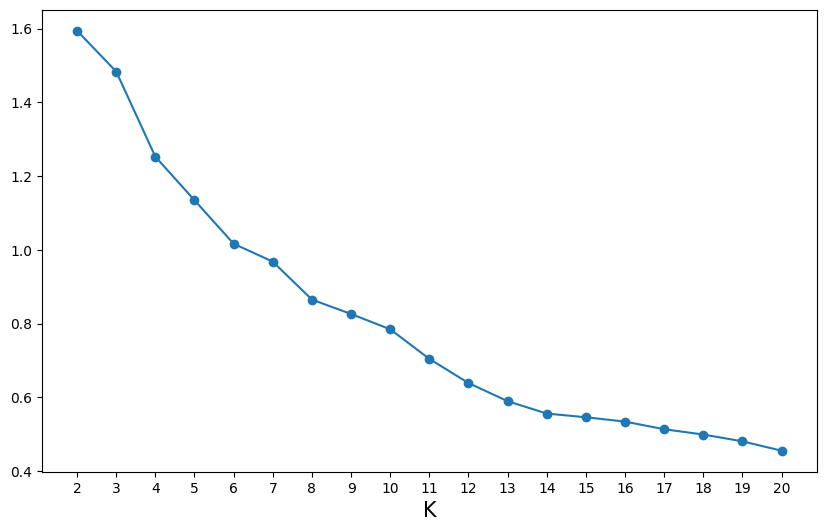

In [7]:
# Plot word_eigen scree plot
eigenvalues = np.sort(es_model.model.doc_eigen)[::-1][1:20] 
plt.figure(figsize=(10, 6))
x_values = np.arange(2, 21)  # Integer x-axis values
plt.plot(x_values, eigenvalues, label="Eigenvalues")
plt.scatter(x_values, eigenvalues)
plt.xlabel(rf"K", fontsize=15)
plt.xticks(x_values)  # Only label integer ticks
plt.savefig("./fig/0331114438/AP_nhyper_600_scree.pdf", format="pdf")
plt.show()

### **Contour plots**

In [8]:
# NOTE: Create marked regions and title names. When running on new dataset, this one should be omitted.
region_coords_list1 = [
	[[0.9,-7.3],[6.85,1.6]],[[11.4,-4.1]],[[5.3,3.85]],[[-3.6,-8.0],[-0.5,10.7]],[[-6.2,-10.5]],[[3.8,14.5]],[[-6.2,0.3]]
]
region_coords_list1 = [np.array(elem) for elem in region_coords_list1]
region_coords_list2 = [['1','2'],['3'],['4'],['5','6'],['7'],['8'],['9']]
region_coords_list2 = [np.array(elem) for elem in region_coords_list2]
titles = ["Finance","Domestic Politics","Geopolitics","Weather","Law & Crime","Transportation Safety","Entertainment"]
titles_ac = ["Fin","DomPol","GeoPol","Wea","LawCri","TraSaf","Ent"]

pts shape for fitting umap is:(39170, 10)


/Users/yguo23/Desktop/Projects/newContextualizedTopicScore/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


finishing fitting umap


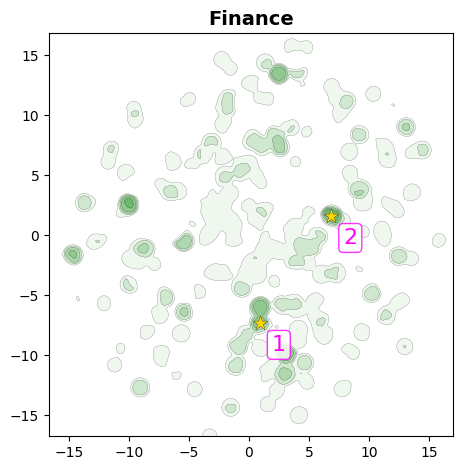

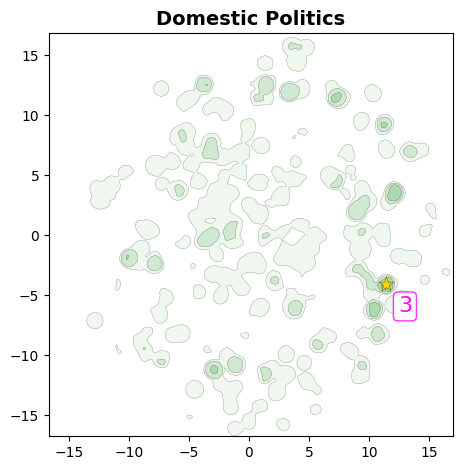

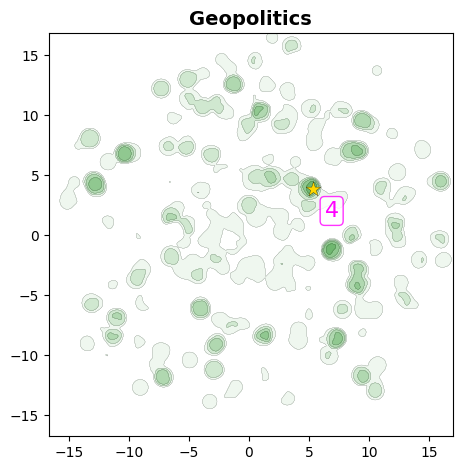

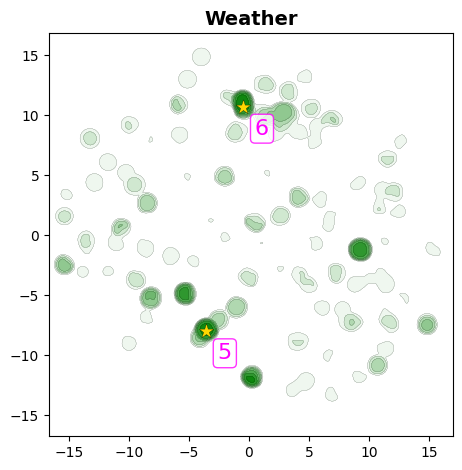

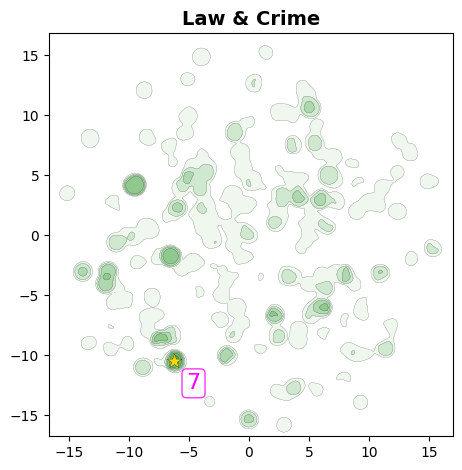

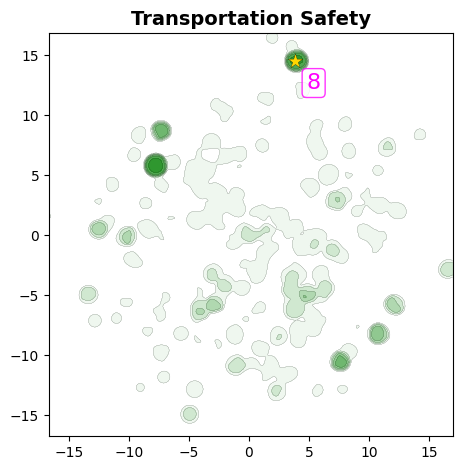

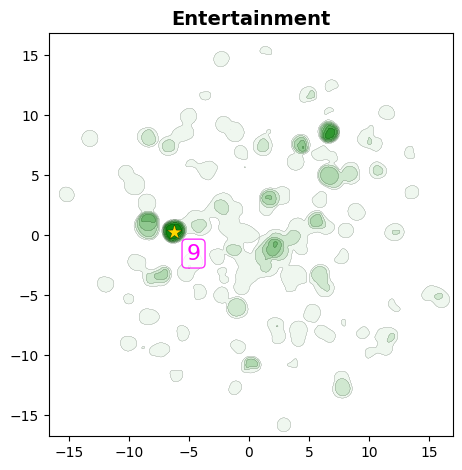

In [9]:
# es_model.plot_density_regions(
# 	seed=seed,
# 	save="./npz/0331114438/AP_contour_plot_variables_umap_10_nn_10_mdist_0.1_sample_0.2_seed_2024.npz",
# 	region_coords_list1=region_coords_list1,
#  	region_coords_list2=region_coords_list2,
#   titles=titles,
#   titles_ac=titles_ac
# )
es_model.plot_density_regions(
	seed=seed,
	save_path="./npz/0331114438/AP_contour_plot_variables_umap_10_nn_10_mdist_0.1_sample_0.2_seed_2024.npz",
	region_coords_list1=region_coords_list1,
 	region_coords_list2=region_coords_list2,
  titles=titles,
  titles_ac=titles_ac,
  save_plot_dir="./fig/0331114438",
  save_plot_tick="AP"
)

### **Words in each contour region**

In [10]:
topic = 0
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([0.9,-7.3]), axis=1) <= 0.2) &
				(es_model.w_word[:, topic] >= 0.45)
)[0]
print(f"Region 1 (Finance): {list(set(word_arr[inds].tolist()))}")

topic = 0
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([6.85,1.6]), axis=1) <= 0.2) &
				(es_model.w_word[:, topic] >= 0.55)
)[0]
print(f"Region 2 (Finance): {list(set(word_arr[inds].tolist()))}")

topic = 1
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([11.4,-4.1]), axis=1) <= 0.2) &
				(es_model.w_word[:, topic] >= 0.4)
)[0]
print(f"Region 3 (Domestic Politics): {list(set(word_arr[inds].tolist()))}")

topic = 2
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([5.3,3.85]), axis=1) <= 0.2) &
				(es_model.w_word[:, topic] >= 0.5)
		)[0]
print(f"Region 4 (Geopolitics): {list(set(word_arr[inds].tolist()))}")

topic = 3
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-3.6,-8.0]), axis=1) <= 0.2) &
				(es_model.w_word[:, topic] >= 0.5)
		)[0]
print(f"Region 5 (Natural Events): {list(set(word_arr[inds].tolist()))}")

topic = 3
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-0.5,10.7]), axis=1) <= 0.3) &
				(es_model.w_word[:, topic] >= 0.6)
		)[0]
print(f"Region 6 (Natural Events): {list(set(word_arr[inds].tolist()))}")

topic = 4
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-6.2,-10.5]), axis=1) <= 0.2) &
				(es_model.w_word[:, topic] >= 0.6)
		)[0]
print(f"Region 7 (Law & Crime): {list(set(word_arr[inds].tolist()))}")

topic = 5
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([3.8,14.5]), axis=1) <= 0.3) &
				(es_model.w_word[:, topic] >= 0.5)
		)[0]
print(f"Region 8 (Transportation Safety): {list(set(word_arr[inds].tolist()))}")

topic = 6
inds = np.where(
				(np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-6.2,0.3]), axis=1) <= 0.1) &
				(es_model.w_word[:, topic] >= 0.7)
		)[0]
print(f"Region 9 (Entertainment): {list(set(word_arr[inds].tolist()))}")

Region 1 (Finance): ['stock', 'earning', 'taxis', 'economist', 'order', 'income', 'inflationary', 'price', 'wage', 'level', 'rate', 'issue', 'margin', 'economic', 'inflation', 'export', 'production', 'demand', 'value', 'economy', 'cent', 'cost', 'future', 'charge', 'stake', 'sale', 'jackson']
Region 2 (Finance): ['fall', 'gain', 'sell', 'jump', 'reach', 'dropping', 'slightly', 'head', 'soar', 'rally', 'mixed', 'remain', 'tumbled', 'depress', 'improve', 'tumble', 'grown', 'add', 'slow', 'end', 'vanish', 'political', 'retreat', 'sank', 'fallen', 'varied', 'range', 'raise', 'surge', 'slip', 'ease', 'risen', 'climb', 'pull', 'decline', 'percent', 'increase', 'advance', 'contract', 'pick', 'push', 'edge', 'advanced', 'drift', 'grow', 'shed', 'settle', 'adjusted', 'depressed', 'collapse', 'expand', 'upward', 'come', 'weaken', 'sink', 'go', 'diminish', 'suffer', 'plunge', 'sharply', 'compare', 'finish', 'recover', 'move', 'rise', 'drop', 'shoot', 'hit', 'lose', 'maintain']
Region 3 (Domestic 

### **Word heptagon for different <code>bandwidth</code>**

bandwidth is 0.1


Calculating word densities.: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


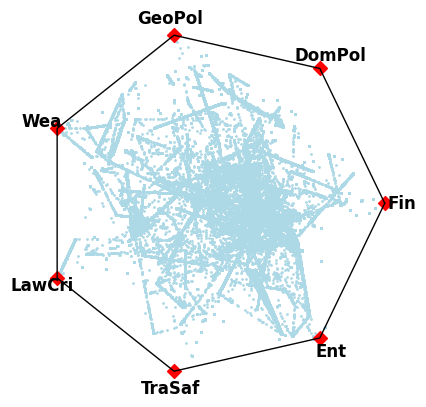

bandwidth is 0.2


Calculating word densities.: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


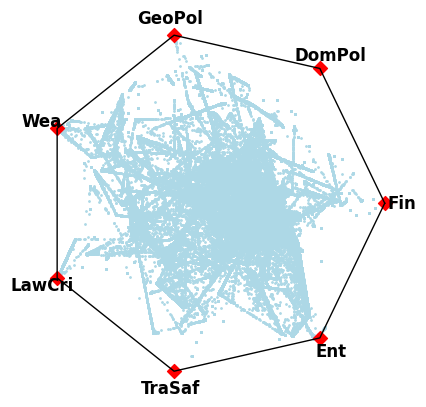

bandwidth is 1.0


Calculating word densities.: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


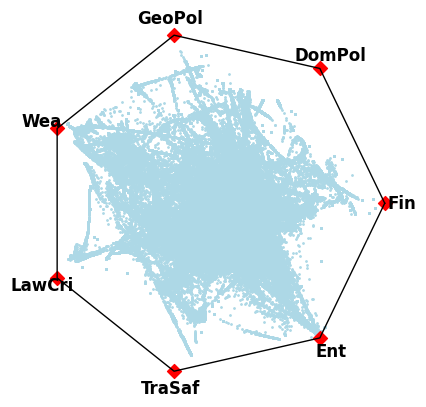

bandwidth is 2.0


Calculating word densities.: 100%|██████████| 2/2 [00:45<00:00, 22.57s/it]


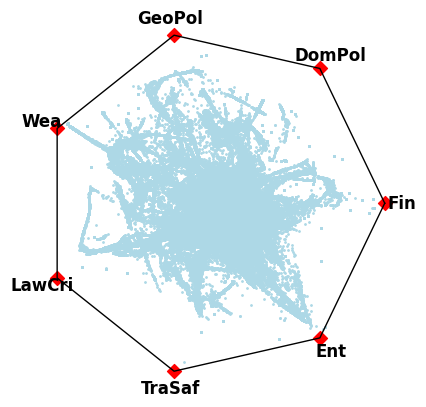

In [11]:
# NOTE: 2. Plot word heptagon with different bandwidth.
for bandwidth in [0.1,0.2,1.0,2.0]:
# es_model.fit_topic_score(num_topic=7)
  es_model.get_word_density(bandwidth=bandwidth, down_sample=None, minibatch=True);
  vectors = es_model.word_mixed_member 
  angles = np.linspace(0, 2 * np.pi, 7, endpoint=False)
  heptagon_vertices = np.array([np.cos(angles), np.sin(angles)]).T
  mapped_points = vectors @ heptagon_vertices

  plt.figure()
  plt.plot(*np.append(heptagon_vertices, [heptagon_vertices[0]], axis=0).T, 'k-', lw=1)  
  plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='lightblue', marker='o', s=1.0, label="Mapped points", rasterized=True)
  for i, (x, y) in enumerate(heptagon_vertices):
      plt.text(x * 1.1, y * 1.1, titles_ac[i], ha='center', va='center', fontsize=12, color='black', fontweight='bold')
      plt.scatter(x, y, color='red', s=50, marker='D')
  plt.gca().set_aspect('equal', adjustable='box')
  # word = "bank"
  # inds = np.where(word_arr==word)[0]
  # plt.scatter(mapped_points[inds, 0], mapped_points[inds, 1], color='red', marker='o', s=5.0)
  plt.axis('off')
  # plt.title("Point distribution for "+"\'"+word+"\'",size=20, pad=20)
  plt.savefig(f"fig/0331114438/AP_nhyper_600_bw_{bandwidth}.pdf",format="pdf",bbox_inches="tight",dpi=600)
  plt.show()

### **Document heptagon**

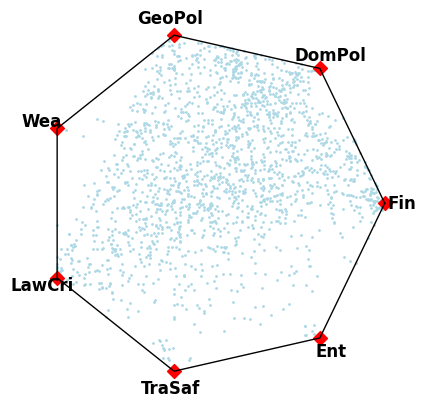

In [12]:
# NOTE: 3. Plot document heptagon.
vectors = es_model.model.W_hat.T
angles = np.linspace(0, 2 * np.pi, 7, endpoint=False)
heptagon_vertices = np.array([np.cos(angles), np.sin(angles)]).T
mapped_points = vectors @ heptagon_vertices

plt.figure()
plt.plot(*np.append(heptagon_vertices, [heptagon_vertices[0]], axis=0).T, 'k-', lw=1)  
plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='lightblue', marker='o', s=1.0, label="Mapped points", rasterized=True)
for i, (x, y) in enumerate(heptagon_vertices):
    plt.text(x * 1.1, y * 1.1, titles_ac[i], ha='center', va='center', fontsize=12, color='black', fontweight='bold')
    plt.scatter(x, y, color='red', s=50, marker='D')
plt.gca().set_aspect('equal', adjustable='box')

# word = "bank"
# inds = np.where(word_arr==word)[0]
# plt.scatter(mapped_points[inds, 0], mapped_points[inds, 1], color='red', marker='o', s=5.0)
plt.axis('off')
# plt.title("Point distribution for "+"\'"+word+"\'",size=20, pad=20)
plt.savefig(f"fig/AP/AP_nhyper_600_document_heptagon.pdf",format="pdf",bbox_inches="tight",dpi=600)
plt.show()